In [1]:
from pathlib import Path
import math
import copy
import pdb

In [2]:
Path.ls = lambda x: list(x.iterdir())

In [3]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set()

In [5]:
import torch

In [6]:
# Load data
data_path = Path('./data')
strokes = np.load(data_path/'strokes-py3.npy', allow_pickle=True)
with open(data_path/'sentences.txt') as f:
    texts = f.readlines()

In [7]:
# Sanity check
len(strokes), len(texts)

(6000, 6000)

In [8]:
# function to plot a single stroke
def plot_stroke(stroke, label=None):
    x,y = np.cumsum(stroke[:,1]), np.cumsum(stroke[:,2])
    x_len = x.max() - x.min()
    y_len = y.max() - y.min()
    plt.figure(figsize=(2*x_len/y_len,3))
    pen_lifts = np.flatnonzero(stroke[:,0])
    begin = 0
    for idx in pen_lifts:
        plt.plot(x[begin:idx],y[begin:idx], 'k')
        begin = idx + 1
    if label is not None:
        plt.title(label,fontsize=15) 
    plt.tight_layout()
    plt.axis('off')
    plt.show()

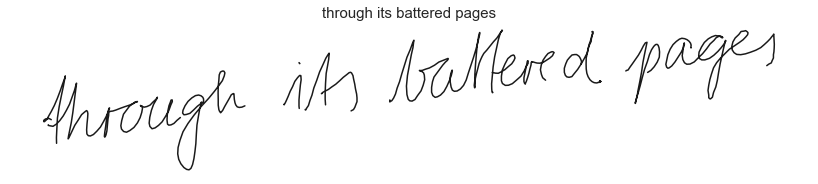

In [9]:
# Plot Strokes
idx = -1
plot_stroke(strokes[idx],texts[idx])

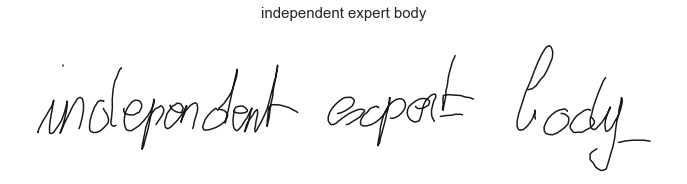

In [10]:
idx = 17
plot_stroke(strokes[idx],texts[idx])

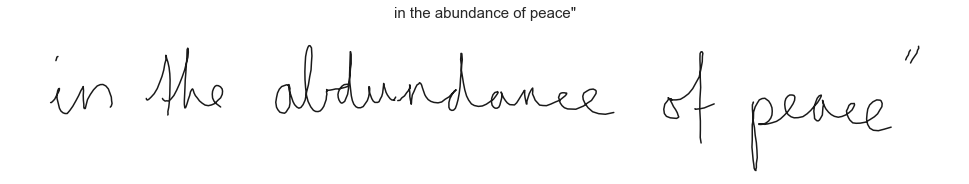

In [11]:
idx = 0
plot_stroke(strokes[idx],texts[idx])

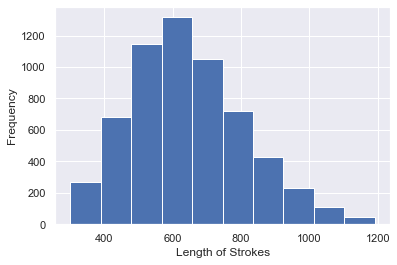

In [12]:
# histogram of sequence lengths
lengths = [len(s) for s in strokes]
plt.hist(lengths,bins=10)
plt.ylabel('Frequency')
plt.xlabel("Length of Strokes")
plt.show()

In [13]:
# Check need for normalization, already in nomalized format
all_x =np.array([x for s in strokes for x in s[:,1]])
all_y =np.array([y for s in strokes for y in s[:,2]])
print(f"X coord -> Mean: {all_x.mean()} STD: {all_x.std()} ")
print(f"Y coord -> Mean: {all_y.mean()} STD: {all_y.std()} ")

X coord -> Mean: 0.41248124837875366 STD: 2.0786476135253906 
Y coord -> Mean: -0.006003160960972309 STD: 1.8560572862625122 


In [14]:
# ADD start token
START=[[3,0,0]]
def add_start(strokes):
    new_strokes = copy.deepcopy(strokes)
    for i in range(len(strokes)):
        new_strokes[i] = np.r_[START,new_strokes[i]]
    return new_strokes

In [15]:
final_strokes = add_start(strokes)

In [16]:
# Split last 10 % as validation
split = int(0.1*len(strokes))
train_strokes = final_strokes[:-split]
valid_strokes = final_strokes[-split:]
print(f"Length Train Set: {len(train_strokes)}")
print(f"Length Val Set: {len(valid_strokes)}")

Length Train Set: 5400
Length Val Set: 600


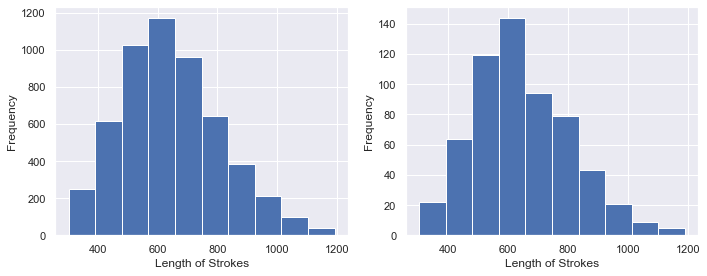

In [17]:
# Sanity check train and valid data have similar distributions
train_lens = [len(s) for s in train_strokes]
valid_lens = [len(s) for s in valid_strokes]
_,axs = plt.subplots(1,2, figsize=(10,4), sharex=True)
axs[0].hist(train_lens)
axs[1].hist(valid_lens)
plt.setp(axs[:], xlabel="Length of Strokes")
plt.setp(axs[:], ylabel='Frequency')
plt.tight_layout()
plt.show()


In [18]:
PAD = [[2,0,0]]
shuffle_bucket = lambda bucket: np.random.permutation(bucket)

In [19]:
# Smarter way to shuffle as random shuffling leads to a lot of padding
def get_buckets(strokes,batch_sz,buffer):
    # Sort acc to length
    strokes = sorted(strokes, key= lambda x:len(x))
    # Divide the data into buckets of size batch_sz*buffer
    total_buckets = math.ceil(len(strokes)/(batch_sz*buffer))
    all_buckets = []
    for i in range(total_buckets):
        one_bucket = strokes[i*batch_sz*buffer : (i+1)*batch_sz*buffer]
        # Fix seq_len of a bucket by padding samples
        seq_len = max([len(s) for s in one_bucket])
        for j in range(len(one_bucket)): # len of last bucket can be different
            diff = seq_len - len(one_bucket[j])
            if diff != 0:
                pad = np.array(PAD*diff)
                one_bucket[j] = np.r_[one_bucket[j],pad]

        all_buckets.append(np.stack(one_bucket))
    return all_buckets

In [20]:
def get_xy(batch,max_bptt,sig,is_valid):
    # Random bptt lenght
    if is_valid:
        bptt, sig = max_bptt, 0
    else: bptt = np.random.randint(max_bptt-100, max_bptt)
    #print("BPTT: ", bptt)
    seq_len = batch.shape[1]
    # x.shape[1] != y.shape[1] for the last sequence
    # hence use seq_len-1 below 
    total_seq = (seq_len-1) // bptt
    x_seqs, y_seqs = [],[]
    for k in range(total_seq):
        x = batch[:, k*bptt : (k+1)*bptt]
        y = batch[:, k*bptt+1 : (k+1)*bptt+1]
        x_seqs.append(x), y_seqs.append(y)
    # Get last sequence only if significant (> sig*bptt)
    rem = (seq_len-1)%bptt
    if rem > sig*bptt:
        x = batch[:, (k+1)*bptt : -1]
        y = batch[:, (k+1)*bptt+1 :]
        x_seqs.append(x), y_seqs.append(y)
    return x_seqs, y_seqs

In [192]:
# Shuffle buckets and yield batches
def batch_loader(strokes, batch_sz, max_bptt=300, buffer=2, sig=0, is_valid=False):
    all_buckets = get_buckets(strokes, batch_sz, buffer)
    total_bz = math.ceil(len(strokes)/batch_sz)
    for bucket in all_buckets:
        bucket = shuffle_bucket(bucket)
        num_bucket_batches = math.ceil(len(bucket)/batch_sz)
        for i in range(num_bucket_batches):
            # Get one batch from bucket
            batch = bucket[i*batch_sz : (i+1)*batch_sz]
            new_batch = True 
            x_seqs, y_seqs = get_xy(batch, max_bptt, sig, is_valid)
            for x,y in zip(x_seqs, y_seqs):
                yield x.astype(np.float32),y.astype(np.float32),new_batch
                new_batch = False

In [22]:
def check_gpu():
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    return device

In [23]:
# dataloaders
train_loader = lambda: batch_loader(train_strokes, batch_sz=256, max_bptt=350, sig=0.2)
valid_loader = lambda: batch_loader(valid_strokes, batch_sz=356, max_bptt=350, is_valid=True)
device = check_gpu()

In [24]:
# sanity check
for x,y,new_batch in valid_loader():
    print("NEW BATCH:", new_batch)
    print(y.shape)

NEW BATCH: True
(356, 350, 3)
NEW BATCH: False
(356, 350, 3)
NEW BATCH: False
(356, 350, 3)
NEW BATCH: False
(356, 140, 3)
NEW BATCH: True
(244, 350, 3)
NEW BATCH: False
(244, 350, 3)
NEW BATCH: False
(244, 350, 3)
NEW BATCH: False
(244, 140, 3)


In [193]:
# sanity check
i = 0
for x,y,new_batch in train_loader():
    i = i+1
i

> <ipython-input-192-a4f54db2bee0>(6)batch_loader()
      4     total_bz = math.ceil(len(strokes)/batch_sz)
      5     pdb.set_trace()
----> 6     for bucket in all_buckets:
      7         bucket = shuffle_bucket(bucket)
      8         num_bucket_batches = math.ceil(len(bucket)/batch_sz)

512
436


BdbQuit: 

In [70]:
n = 50
[1e-6 * (1e7)**(i/n) for i in range(n)]

[1e-06,
 1.3803842646028846e-06,
 1.905460717963247e-06,
 2.6302679918953817e-06,
 3.6307805477010132e-06,
 5.0118723362727224e-06,
 6.918309709189363e-06,
 9.549925860214362e-06,
 1.3182567385564071e-05,
 1.8197008586099834e-05,
 2.5118864315095805e-05,
 3.467368504525316e-05,
 4.7863009232263824e-05,
 6.60693448007596e-05,
 9.1201083935591e-05,
 0.0001258925411794167,
 0.00017378008287493755,
 0.00023988329190194915,
 0.000331131121482591,
 0.000457088189614875,
 0.0006309573444801934,
 0.0008709635899560804,
 0.0012022644346174128,
 0.001659586907437561,
 0.0022908676527677724,
 0.0031622776601683794,
 0.004365158322401661,
 0.0060255958607435805,
 0.008317637711026716,
 0.011481536214968821,
 0.01584893192461113,
 0.021877616239495523,
 0.030199517204020167,
 0.041686938347033554,
 0.057543993733715736,
 0.07943282347242808,
 0.10964781961431845,
 0.15135612484362077,
 0.20892961308540398,
 0.2884031503126607,
 0.39810717055349754,
 0.5495408738576241,
 0.7585775750291833,
 1.04712

In [150]:

i

59

In [27]:
# Start defining models
import torch.nn as nn
class InLayer(nn.Module):
    def __init__(self,fc_size=10):
        super().__init__()
        self.fc = nn.Linear(3,fc_size)
        self.activation = nn.Tanh()
    def forward(self,x):
        x = self.fc(x)
        return self.activation(x) 

In [28]:
class RecurLayer(nn.Module):
    def __init__(self,ip_dims=10,num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        self.rnns = nn.ModuleList([nn.LSTM(ip_dims,ip_dims,batch_first=True)])
        for i in range (num_layers-1):
            self.rnns.append(nn.LSTM(ip_dims*2,ip_dims,batch_first=True))
    def forward(self,x,prev_state=None):
        if prev_state == None:
            prev_state = [None]*self.num_layers
        cat_xs, new_state = [], []
        skip_x = x.clone()
        for i in range(self.num_layers):
            new_x,s = self.rnns[i](x,prev_state[i])
            cat_xs.append(new_x), new_state.append(s)
            x = torch.cat([skip_x,new_x],2) # skip connection inputs
        return torch.cat(cat_xs, 2), new_state # outputs from all layers

In [29]:
class MixtureDensity(nn.Module):
    def __init__(self,ip_dims,num):
        super().__init__()
        self.num = num
        self.ce = nn.Linear(ip_dims,3)
        self.pi = nn.Linear(ip_dims,num)
        self.sigma = nn.Linear(ip_dims,num*2)
        self.rho = nn.Linear(ip_dims,num)
        self.mu = nn.Linear(ip_dims,num*2)
    def forward(self,x):
        ce = self.ce(x)
        pi = self.pi(x)
        rho = self.rho(x)
        shape = x.size()
        sigma = self.sigma(x).view(shape[0],shape[1],self.num,2)
        mu = self.mu(x).view(shape[0],shape[1],self.num,2)
        return ce,pi,rho,sigma,mu

In [30]:
class FinalActivation(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)
        self.softplus = nn.Softplus()
        self.tanh = nn.Tanh()
    def forward(self,ce,pi,rho,sigma,mu):
        pi = self.softmax(pi)
        rho = self.tanh(rho)
        sigma = self.softplus(sigma)
        return ce,pi,rho,sigma,mu

In [31]:
class AutoGen(nn.Module):
    def __init__(self,fc_size=20,rnn_layers=2,n_g=10):
        super().__init__()
        self.inlayer = InLayer(fc_size)
        self.recurlayer = RecurLayer(fc_size,rnn_layers)
        self.outlayer = MixtureDensity(rnn_layers*fc_size,n_g)
        self.activation = FinalActivation()
    def forward(self,x,prev_state):
        x = self.inlayer(x)
        x,new_state = self.recurlayer(x,prev_state)
        params = self.outlayer(x)
        params = self.activation(*params)
        return params, tuple(new_state)

In [32]:
x,y,new_batch  = next(train_loader())


In [33]:
x.shape,y.shape,new_batch
x = torch.as_tensor(x)
y = torch.as_tensor(y)

In [34]:
model = AutoGen()
params,_ = model(x,None)

In [35]:
ce,pi,rho,sigma,mu = params

In [36]:
ce.shape,pi.shape,rho.shape,sigma.shape, mu.shape

(torch.Size([256, 347, 3]),
 torch.Size([256, 347, 10]),
 torch.Size([256, 347, 10]),
 torch.Size([256, 347, 10, 2]),
 torch.Size([256, 347, 10, 2]))

In [185]:
# from torch.distributions.multivariate_normal import MultivariateNormal
# sigma_matrix = torch.zeros(*sigma.size(),2, dtype=sigma.dtype)
# sigma_matrix.shape
# sigma_matrix[...,0,0] = sigma[...,0]
# sigma_matrix[...,1,1] = sigma[...,1]
# sigma_matrix[...,0,1] = rho*torch.prod(sigma,axis=-1)
# sigma_matrix[...,1,0] = rho*torch.prod(sigma,axis=-1)
# mult = MultivariateNormal(mu,sigma_matrix)

In [37]:
def calc_prob(target,rho,sigma,mu):
    sigma = sigma + 1e-8
    target = target.unsqueeze(-2).expand_as(mu)
    norm1 = math.pi*torch.prod(sigma,-1)*torch.sqrt(1-rho**2+1e-12)
    z = (((target-mu)**2)/sigma**2).sum(-1) - 2*rho*torch.prod(target-mu,-1)/torch.prod(sigma,-1)
    norm2 = 2*(1-rho**2)
    ans = torch.exp(-z/norm2)/norm1
    return ans

In [47]:
# # Mask pad tokens
# loss_ce = nn.CrossEntropyLoss(reduction='none')
# def mask_loss_func(preds, y_true):

#     intrp,coords = y_true[:,:,0].long(), y_true[:,:,1:]
#     mask = (~(intrp==2)).float()
#     ce_preds,pi = preds[:2]
#     ce_preds = ce_preds.transpose(-1,1)
#     ce = loss_ce(ce_preds, intrp)
#     ce = mask*ce

#     probs = pi * calc_prob(coords,*preds[2:]) 
#     probs = torch.sum(probs,-1)
#     nll = -mask*(torch.log(probs+ 1e-10))
#     if torch.isnan(nll.sum()):
#         pdb.set_trace()
#     return (ce.sum()+ nll.sum()) /mask.sum()

In [48]:
class LossMetric():
    def __init__(self):
        self.loss_ce = nn.CrossEntropyLoss(reduction='None')
        self.total_celoss = 0
        self.total_nllloss = 0
        self.total_samples = 0
    def mask_loss(self,preds,y_true):
        # Mask pad tokens
        intrp,coords = y_true[:,:,0].long(), y_true[:,:,1:]
        mask = (~(intrp==2)).float()
        ce_preds,pi = preds[:2]
        ce_preds = ce_preds.transpose(-1,1)
        ce = loss_ce(ce_preds, intrp)
        ce = mask*ce

        probs = pi * calc_prob(coords,*preds[2:]) 
        probs = torch.sum(probs,-1)
        nll = -mask*(torch.log(probs+ 1e-10))
        # if torch.isnan(nll.sum()):
        #     pdb.set_trace()
        return ce.sum(), nll.sum(), mask.sum()
    def update_state(self, ce, nll, num):
        ce,nll,num = ce.item(), nll.item(), num.item()
        self.total_nllloss += nll
        self.total_celoss += ce
        self.total_samples += num
    def get_loss(preds,y_true):
        ce, nll, mask = mask_loss(preds,y_true)
        update_state(ce.clone().detach(),nll.clone().detach(),mask.clone().detach())
        return (ce + nll)/mask
    def result(self):
        ce = self.total_celoss/ self.total_samples
        nll = self.total_nllloss/ self.total_samples
        return ce,nll, ce+nll
    def reset_state(self):
        self.total_celoss = 0
        self.total_nllloss = 0
        self.total_samples = 0


In [49]:
# track metrics for the entire epochs
train_metric = LossMetric()
valid_metric = LossMetric()

In [ ]:
# detach hidden states to prevent backprop through the entire sequence
def repackage_hidden(prev_state):
    if isinstance(prev_state,torch.Tensor):
        return prev_state.detach()
    else:
        return tuple(repackage_hidden(h) for h in prev_state)

In [57]:
def train_epoch(model,train_loader,opt,clip_norm):
    model.train()
    train_metric.reset_state()
    for x,y,new_batch in train_loader():
        x,y = torch.as_tensor(x).to(device), torch.as_tensor(y).to(device)
        if new_batch: prev_state = None
        else: prev_state = repackage_hidden(prev_state)
        params,prev_state = model(x, prev_state)
        loss = train_metric.get_loss(params,y)
        model.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),clip_norm)
        opt.step()

In [58]:
def valid_epoch(model,valid_loader):
    model.eval()
    valid_metric.reset_state()
    with torch.no_grad():
        for x,y,new_batch in valid_loader():
            x,y = torch.as_tensor(x).to(device), torch.as_tensor(y).to(device)
            if new_batch: prev_state = None
            else: prev_state = repackage_hidden(prev_state)
            params,prev_state = model(x, prev_state)    
            _ = valid_metric.get_loss(params,y)

In [62]:
import itertools
def fit(model,epochs,max_lr,clip=0.4,wd=0.01):

    # separate out rnn layers,  wd = 0
    other_params = [p.parameters() for p in model.children() if p != model.recurlayer]
    opt =  torch.optim.AdamW([{'params':model.recurlayer.parameters(),'weight_decay':0},
                       {'params':itertools.chain(*other_params)}],
                       lr = max_lr,weight_decay = wd, betas= [0.95,0.999])
    # simple lr schedule
    lr = list(np.linspace(1e-6,max_lr,epochs//2)) + list(np.linspace(max_lr,1e-6,math.ceil(epochs/2)))
    mom = list(np.linspace(0.95,0.85,epochs//2)) + list(np.linspace(0.85,0.95,math.ceil(epochs/2)))
    train_logs = {'ce_tl':[],'nll_tl':[],'tot_tl':[],'ce_vl':[],'nll_vl':[],'tot_vl':[],}
    best_valid_loss = float('inf')
    for e in tqdm(range(epochs)):
        # change lr and momentum 
        opt.defaults['lr'] = lr[e]
        opt.defaults['betas'][0] = mom[e]
        train_epoch(model,train_loader,opt,clip)
        valid_epoch(model,valid_loader)
        ce_tl,nll_tl,tot_tl = train_metric.result()
        ce_vl, nll_vl, tot_vl = valid_metric.result()

        if e%5 == 0 or e == epochs-1:
            tqdm.write(f'\nEpoch:{e}  Train Loss: {tot_tl:.4f}  Valid Loss: {tot_vl:.4f}    Best Valid:{best_valid_loss:.3f}') 

        if  tot_vl < best_valid_loss:
            best_valid_loss = tot_vl
            best_model = copy.deepcopy(model)
        
        train_logs['tot_tl'].append(tot_tl)
        train_logs['ce_tl'].append(ce_tl)
        train_logs['nll_tl'].append(nll_tl)
        train_logs['tot_vl'].append(tot_vl)
        train_logs['ce_vl'].append(ce_vl)
        train_logs['nll_vl'].append(nll_vl)

    return best_model.to(device), train_logs